# Integration
- This notebook will be integrating the final conclusions of the individual analysis that can be found in the same directory

# Variables
1. Housing Resale Prices
2. Marriage Count
3. Groceries
4. Income
5. Food Costs
6. School Fees

# Models Considered (Specific Variables)
- Logistic Regression
- Random Forest Classifier
- Bagging Classifier
    - We have trained our models multiple times using different seeds to get the top 5 best performing ones
    - So, we would like to see if simply using the best model trained or combining the top 5 will give a better model

During our analysis, we noticed that our specific variables can end up using different number of data points, due to lack of data points. This can range from only 100+ variables to about 500+ variables

We have also made changes to the dataset in our individual analysis, which may not be same for others.

Hence, we decided create separate models for each variable.

# Models Considered (Integrated)
Due to us training seperate models for our variables, integrating the datasets will result in missing values for some columns

Unfortunately, while the `Random Forest` algorithm should be able to support missing values, it seems that the `scikit-learn` library implementation does not support it.

Further research suggests to use `Gradient Boosting` to combine our separate models. However, due to how we approached this project, our models have been trained on different number of features, this caused some issues as some of this ensemble models requires the models to be trained on the same set of features.




# Performance Evaluation / Cross-Validation Techniques
We wanted to find some way to evaluate our models' performance and also to ensure that our performance is not a result of overfitting

We narrowed down to 2 techniques, due to our small datasets:
- K-Fold Cross-Validation
    - The process of splitting data set into `k` equally sized groups
    - Models will be trained on `k-1` of these folds and tested on the remaining one
    - This process will be repeated to test on every fold
        - E.g. If the number of folds is 3, we will get 3 trained models
    - We will then get the average of the 3 models' performance to evaluate our model
- Leave-One-Out Cross-Validation (LOOCV)
    - Similar to K-Fold, but it test on only 1 of the data points and train the model on the rest

While we might get a better performance evaluation if we use LOOCV, it gets very computational expensive despite our small dataset. Hence, we decided to use K-Fold, and to keep each fold to about 100 data points each

In [43]:
# Import required libraries
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
sb.set()

from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

import random

# Getting 5 random seeds
seeds = []
for i in range(5):
    seeds.append(random.randint(0, 100000))

# Main Dataset: Birth Count
## 1. Data Reading

In [2]:
# Importing birth rate data
birthData = pd.read_csv('Datasets/Birth_Rate_clean.csv')
birthData.tail()

,Data Series,2022 Dec,2022 Nov,2022 Oct,2022 Sep,2022 Aug,2022 Jul,2022 Jun,2022 May,2022 Apr,...,1960 Oct,1960 Sep,1960 Aug,1960 Jul,1960 Jun,1960 May,1960 Apr,1960 Mar,1960 Feb,1960 Jan
10,Total Female Live-Births By Ethnic Group,1422,1452,1506,1539,1458,1426,1379,1420,1306,...,2754,2478,2583,2547,2451,2586,2388,2396,2166,2360
11,Malays,308,323,333,363,319,287,330,320,331,...,474,441,472,426,413,432,393,418,402,394
12,Chinese,825,797,856,869,799,831,748,831,705,...,2013,1754,1856,1848,1794,1910,1776,1756,1523,1701
13,Indians,158,182,161,163,150,173,155,142,154,...,218,243,200,218,210,196,179,178,192,227
14,Other Ethnic Groups,131,150,156,144,190,135,146,127,116,...,49,40,55,55,34,48,40,44,49,38


## 2. Data Cleaning

In [3]:
# Update index name
birthData = birthData.rename(columns = {'Data Series':'Date'})
birthData.set_index('Date',inplace=True)
birthData = birthData.rename(columns=lambda x: x.strip())
birthData.columns = pd.DatetimeIndex(birthData.columns).to_period('M')

# Switch rows and columns (Transpose)
birthData = birthData.T
birthData = birthData.rename(columns=lambda x: x.strip())
birthData = birthData.sort_index()
birthData.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 756 entries, 1960-01 to 2022-12
Freq: M
Data columns (total 15 columns):
 #   Column                                    Non-Null Count  Dtype
---  ------                                    --------------  -----
 0   Total Live-Births By Ethnic Group         756 non-null    int64
 1   Malays                                    756 non-null    int64
 2   Chinese                                   756 non-null    int64
 3   Indians                                   756 non-null    int64
 4   Other Ethnic Groups                       756 non-null    int64
 5   Total Male Live-Births By Ethnic Group    756 non-null    int64
 6   Malays                                    756 non-null    int64
 7   Chinese                                   756 non-null    int64
 8   Indians                                   756 non-null    int64
 9   Other Ethnic Groups                       756 non-null    int64
 10  Total Female Live-Births By Ethnic Group  7

         Total Live-Births By Ethnic Group
1960-01                               4981
1960-02                               4596
1960-03                               4964
1960-04                               4904
1960-05                               5244


<AxesSubplot:>

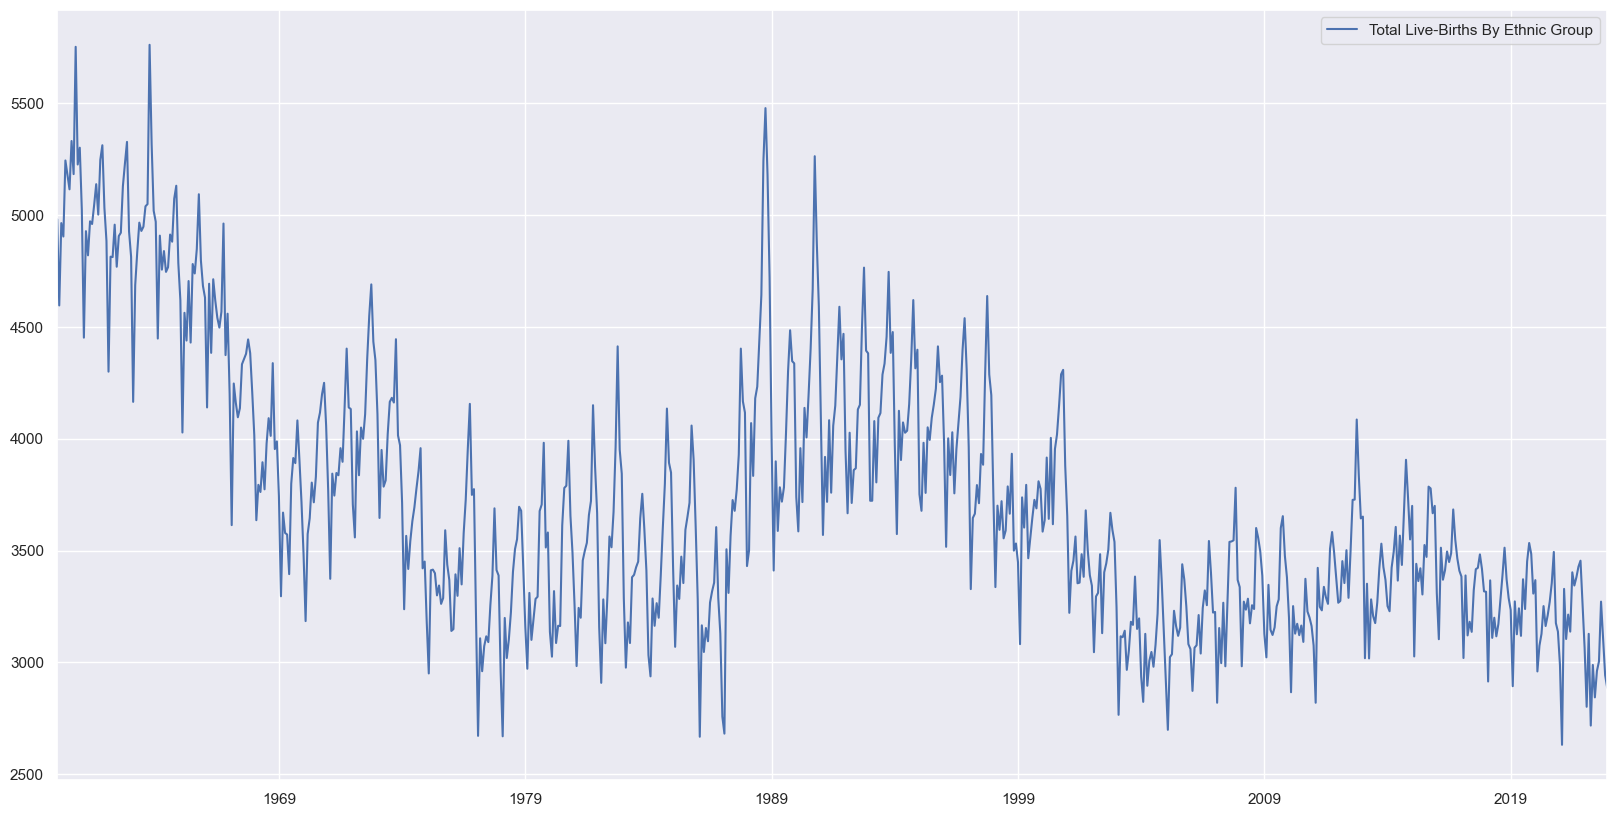

In [4]:
# Getting required column
babies = pd.DataFrame(birthData['Total Live-Births By Ethnic Group'])

print(babies.head())
babies = babies.astype('int64')
babies.plot(figsize=(20, 10))

# Variable 1: Housing Resale Prices (Chee Han)
[Analysis](Housing%20Prices%20Analysis.ipynb)

## 1. Data Reading

In [5]:
houseResale = pd.concat(map(pd.read_csv, ['Datasets/Resale Flat Prices/Resale Approval Date 1990-1999.csv', 'Datasets/Resale Flat Prices/Resale Approval Date 2000-Feb-2012.csv', 'Datasets/Resale Flat Prices/Resale Registration Date Mar-2012-Dec-2014.csv', 'Datasets/Resale Flat Prices/Resale Registration Date Jan-2015-Dec-2016.csv', 'Datasets/Resale Flat Prices/Resale Registration Date Jan-2017-Onwards.csv']))
houseResale.tail()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,remaining_lease
149698,2023-03,YISHUN,EXECUTIVE,325,YISHUN CTRL,10 TO 12,146.0,Maisonette,1988,800000.0,64 years 08 months
149699,2023-03,YISHUN,EXECUTIVE,356,YISHUN RING RD,01 TO 03,146.0,Maisonette,1988,800000.0,64 years 06 months
149700,2023-03,YISHUN,EXECUTIVE,387,YISHUN RING RD,04 TO 06,142.0,Apartment,1988,770000.0,64 years 03 months
149701,2023-03,YISHUN,EXECUTIVE,792,YISHUN RING RD,10 TO 12,146.0,Maisonette,1987,818000.0,63 years 05 months
149702,2023-03,YISHUN,EXECUTIVE,640,YISHUN ST 61,01 TO 03,164.0,Apartment,1992,975000.0,68 years 03 months


## 2. Data Cleaning & Preparation

In [6]:
# Updating month column (Name and Datatype)
houseResale = houseResale.rename(columns = {'month':'Date'})
houseResale['Date'] = pd.to_datetime(houseResale['Date'])
houseResale['Date'] = houseResale['Date'].dt.strftime('%Y-%m')

# Standardizing flat_type and flat_models
houseResale['flat_type'] = ['MULTI-GENERATION' if x=='MULTI GENERATION' else x for x in houseResale['flat_type']]
houseResale['flat_model'] = [x.upper() for x in houseResale['flat_model']]

# Removing outliers
tempFrame = houseResale[['Date', 'flat_type', 'flat_model', 'resale_price']].copy()
flatType = ['1 ROOM', '3 ROOM', '4 ROOM', '5 ROOM', 'EXECUTIVE', 'MULTI-GENERATION']
separateType = []

for flat in flatType:
    temp = tempFrame.loc[tempFrame['flat_type'] == flat]
    Q3 = temp['resale_price'].quantile(0.25)
    Q1 = temp['resale_price'].quantile(0.75)
    IQR = Q1-Q3
    separateType.append(temp[~((temp['resale_price'] < (Q1 - 1.5*IQR)) | (temp['resale_price'] > (Q3 + 1.5*IQR)))])
    
# Ignore flat_model
tempFrame = pd.concat(separateType).reset_index().drop(['index'], axis=1)
tempFrame = tempFrame.groupby(['Date', 'flat_type'])['resale_price'].mean().round(2).to_frame()
tempFrame = tempFrame.round(2)
tempFrame = tempFrame.rename(columns={'resale_price': 'avg_resale'}).reset_index()

In [7]:
tempFrame.head()

,Date,flat_type,avg_resale
0,1990-01,3 ROOM,77980.00
1,1990-01,4 ROOM,149500.00
2,1990-02,3 ROOM,75690.91
3,1990-02,4 ROOM,152533.33
4,1990-03,3 ROOM,82060.00


In [8]:
# Getting avg_resale dataframe for 3R, 4R and 5R
temp3R = tempFrame.loc[tempFrame['flat_type'] == '3 ROOM']
temp3R = temp3R.set_index('Date')
temp3R.index = pd.to_datetime(temp3R.index).to_period('M')

temp4R = tempFrame.loc[tempFrame['flat_type'] == '4 ROOM']
temp4R = temp4R.set_index('Date')
temp4R.index = pd.to_datetime(temp4R.index).to_period('M')

temp5R = tempFrame.loc[tempFrame['flat_type'] == '5 ROOM']
temp5R = temp5R.set_index('Date')
temp5R.index = pd.to_datetime(temp5R.index).to_period('M')

In [9]:
# Getting copy of birth dataframe
housingBaby = pd.DataFrame(birthData['Total Live-Births By Ethnic Group'])
housingBaby['Next Month Birth'] = housingBaby['Total Live-Births By Ethnic Group'].shift(-1)
housingBaby['Prev Month Birth'] = housingBaby['Total Live-Births By Ethnic Group'].shift(1)

# Dropping NaN rows (First and Last Row)
housingBaby = housingBaby.dropna()

housing3R = housingBaby.join(temp3R['avg_resale'], how='inner').rename(columns={'avg_resale': '3R Avg'})
housing4R = housingBaby.join(temp4R['avg_resale'], how='inner').rename(columns={'avg_resale': '4R Avg'})
housing5R = housingBaby.join(temp5R['avg_resale'], how='inner').rename(columns={'avg_resale': '5R Avg'})

housingMerge = pd.concat([housing3R, housing4R, housing5R], axis=1, join='inner')
housingMerge = housingMerge.loc[:,~housingMerge.columns.duplicated(keep='first')]
housingMerge.info()
housingMerge.corr()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 373 entries, 1991-07 to 2022-11
Freq: M
Data columns (total 6 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Total Live-Births By Ethnic Group  373 non-null    int64  
 1   Next Month Birth                   373 non-null    float64
 2   Prev Month Birth                   373 non-null    float64
 3   3R Avg                             373 non-null    float64
 4   4R Avg                             373 non-null    float64
 5   5R Avg                             373 non-null    float64
dtypes: float64(5), int64(1)
memory usage: 20.4 KB


,Total Live-Births By Ethnic Group,Next Month Birth,Prev Month Birth,3R Avg,4R Avg,5R Avg
Total Live-Births By Ethnic Group,1.000000,0.849316,0.845988,-0.508727,-0.434129,-0.311686
Next Month Birth,0.849316,1.000000,0.790944,-0.510863,-0.437168,-0.318515
Prev Month Birth,0.845988,0.790944,1.000000,-0.504473,-0.429592,-0.301726
3R Avg,-0.508727,-0.510863,-0.504473,1.000000,0.984329,0.917998
4R Avg,-0.434129,-0.437168,-0.429592,0.984329,1.000000,0.969291
5R Avg,-0.311686,-0.318515,-0.301726,0.917998,0.969291,1.000000


<AxesSubplot:>

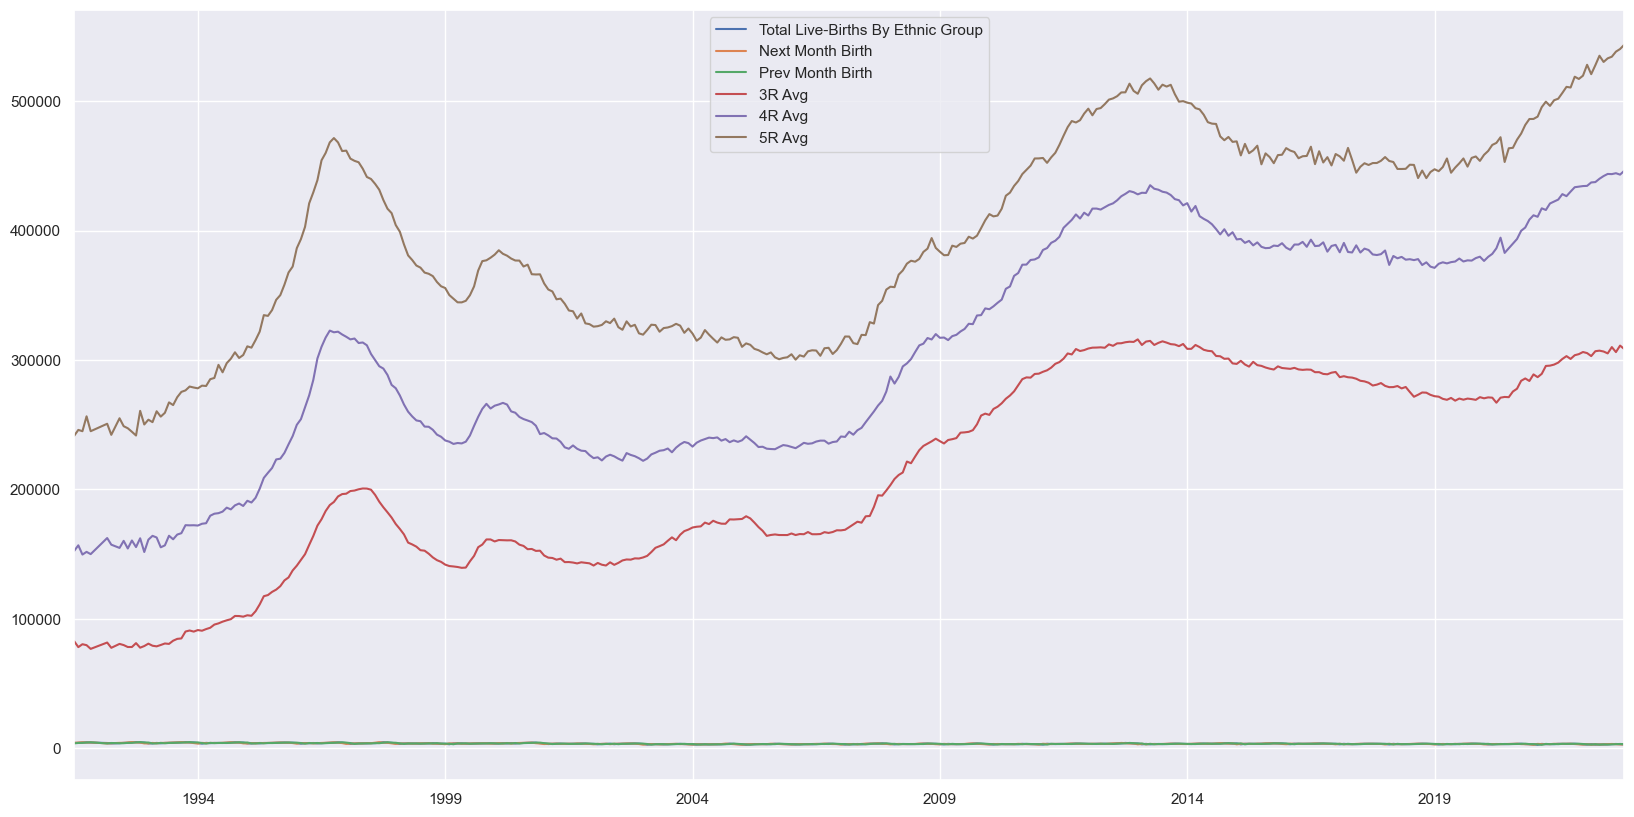

In [10]:
housingMerge.plot(figsize=(20, 10))

## 3. Model Training (Classification - Random Forest)
- Predictors:
    - Total Live-Births by Ethnic Group
    - Prev Month Birth
    - 3R Avg
    - 4R Avg
    - 5R Avg
- Response: Rise-Fall

In [11]:
# Step 1: Creating binary target variable
housingMerge['Rise-Fall'] = (housingMerge['Total Live-Births By Ethnic Group'] > housingMerge['Next Month Birth']).astype(int)

In [42]:
results = []

for seed in seeds:
    # Step 2: Combine features into single dataframe
    # Step 2.1: Predictors
    X = housingMerge[['Total Live-Births By Ethnic Group', 'Prev Month Birth',
                       '3R Avg', '4R Avg', '5R Avg']]

    # Step 2.2: Response
    y = housingMerge['Rise-Fall']
    
    # step 3: Spit data into training and test sets    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
    
    # Step 4: Creating Random Forest Classifier object
    rf = RandomForestClassifier(max_depth=10)
    
    # Step 5: Fit model to training set
    rf.fit(X_train, y_train)
    
    # Step 6: Make predictions on test set
    y_pred = rf.predict(X_test)
    
    # Step 7: Evaluate performance
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    results.append((seed, accuracy, precision, recall, f1, rf))

# Sort results by F1 score in descending order
results.sort(key=lambda x: x[4], reverse=True)

75


In [13]:
for res in results:
    print('----------------------------------------------')
    print(f"Random state {res[0]}:")
    print(f'Accuracy  = {res[1]:.4f}')
    print(f'Precision = {res[2]:.4f}')
    print(f'Recall    = {res[3]:.4f}')
    print(f'F1 score  = {res[4]:.4f}')
print('----------------------------------------------')

----------------------------------------------
Random state 8:
Accuracy  = 0.6800
Precision = 0.6341
Recall    = 0.7429
F1 score  = 0.6842
----------------------------------------------
Random state 62349:
Accuracy  = 0.6267
Precision = 0.7037
Recall    = 0.4872
F1 score  = 0.5758
----------------------------------------------
Random state 68609:
Accuracy  = 0.5867
Precision = 0.5556
Recall    = 0.5714
F1 score  = 0.5634
----------------------------------------------
Random state 71444:
Accuracy  = 0.5200
Precision = 0.5227
Recall    = 0.6053
F1 score  = 0.5610
----------------------------------------------
Random state 87199:
Accuracy  = 0.5600
Precision = 0.4167
Recall    = 0.5556
F1 score  = 0.4762
----------------------------------------------


In [14]:
# Final Model to use for Variable 1
houseMod = results[0][-1]

# Variable 2: Marriage Count (Chee Han)
[Analysis](Marriage%20Analysis.ipynb)

## 1. Data Reading

In [15]:
# Reading Total Marriage data
marriageCount = pd.read_csv("Datasets/Marriage_clean.csv")
marriageCount.head()

,Data Series,2021,2020,2019,2018,2017,2016,2015,2014,2013,...,1970,1969,1968,1967,1966,1965,1964,1963,1962,1961
0,Total Marriages (Number),28329.0,22651.0,25434.0,27007.0,28212.0,27971.0,28322.0,28407.0,26254.0,...,14572,12629,11552,10960,10226,8993,7810,7056,6044,5224
1,First Marriages (Number),22808.0,17789.0,19356.0,20822.0,21806.0,21364.0,21639.0,21555.0,19706.0,...,13889,na,na,na,na,na,na,na,na,na
2,Remarriages (Number),5521.0,4862.0,6078.0,6185.0,6406.0,6607.0,6683.0,6852.0,6548.0,...,683,na,na,na,na,na,na,na,na,na
3,Remarriages - One Partner (Number),3568.0,3104.0,3854.0,3976.0,4227.0,4423.0,4442.0,4682.0,4432.0,...,533,na,na,na,na,na,na,na,na,na
4,Remarriages - Both Partners (Number),1953.0,1758.0,2224.0,2209.0,2179.0,2184.0,2241.0,2170.0,2116.0,...,150,na,na,na,na,na,na,na,na,na


## 2. Data Cleaning & Preparation

In [16]:
# Renaming & setting index column
marriageCount = marriageCount.rename(columns = {'Data Series':'Date'})
marriageCount.set_index('Date',inplace=True)
marriageCount.columns = pd.DatetimeIndex(marriageCount.columns).to_period('M')

# Switch row and columns (Transpose)
marriageCount = marriageCount.T
marriageCount = marriageCount.rename(columns=lambda x: x.strip()).sort_index()

# Update data type to remove decimal point
totalMarriage = marriageCount.rename(columns = {'Total Marriages (Number)':'Total Marriages'}).astype({'Total Marriages':'int'})[['Total Marriages']]

In [17]:
print(len(totalMarriage))
totalMarriage.tail()

61


Date,Total Marriages
2017-01,28212
2018-01,27007
2019-01,25434
2020-01,22651
2021-01,28329


In [18]:
# Removing Outliers
Q3 = totalMarriage['Total Marriages'].quantile(0.25)
Q1 = totalMarriage['Total Marriages'].quantile(0.75)
IQR = Q1-Q3
totalMarriage = totalMarriage[~((totalMarriage['Total Marriages'] < (Q1 - 1.5*IQR)) | (totalMarriage['Total Marriages'] > (Q3 + 1.5*IQR)))]

In [19]:
print(len(totalMarriage))
totalMarriage.tail()

43


Date,Total Marriages
2011-01,27258
2013-01,26254
2018-01,27007
2019-01,25434
2020-01,22651


In [20]:
# Monthly Marriage Rate Calculation
monthlyRate = [1963, 1492, 2041, 1314, 2034, 2220, 1814, 1849, 2315, 2046, 2641, 2867]
sumOfMonthly = sum(monthlyRate)
monthlyRate = [x/sumOfMonthly for x in monthlyRate]

# Breaking down annual to monthly
marriageSplit = pd.DataFrame(columns=['Date', 'Current Marriage Count']).astype({'Current Marriage Count':'int'})
for index, row in totalMarriage.iterrows():
    date = index
    total = row['Total Marriages']
    for i in range(12):
        marriageSplit = pd.concat([marriageSplit, pd.DataFrame({'Date':[date + pd.offsets.MonthEnd(i)], 'Current Marriage Count':[(int)(total*monthlyRate[i])]})])
marriageSplit.set_index('Date',inplace=True)

<AxesSubplot:>

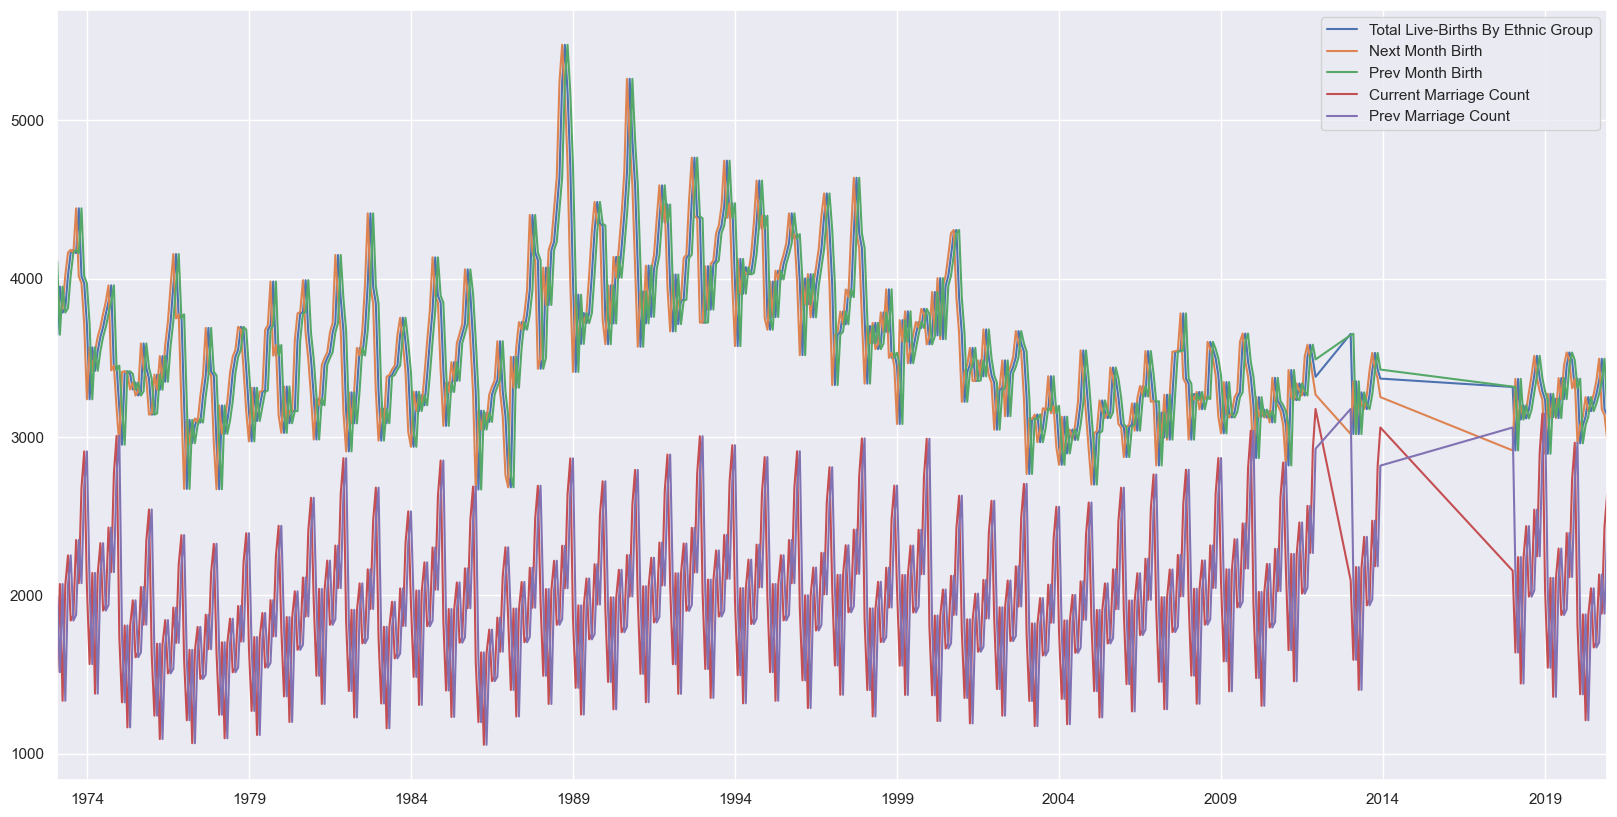

In [21]:
# Copy of Birth Data
marriageBaby = pd.DataFrame(birthData['Total Live-Births By Ethnic Group'])
marriageBaby['Next Month Birth'] = marriageBaby['Total Live-Births By Ethnic Group'].shift(-1)
marriageBaby['Prev Month Birth'] = marriageBaby['Total Live-Births By Ethnic Group'].shift(1)

marriageSplit = pd.concat([marriageBaby, marriageSplit], axis=1, join='inner')
marriageSplit['Prev Marriage Count'] = marriageSplit['Current Marriage Count'].shift(1)

# Remove NaN rows
marriageSplit = marriageSplit.dropna()

marriageSplit.plot(figsize=(20, 10))

## 3. Model Training (Classification - Random Forest)
- Predictors:
    - Total Live-Births by Ethnic Group
    - Prev Month Birth
    - Marriage Count
    - Prev Count
- Response: Rise-Fall

In [22]:
# Step 1: Create binary target variable
marriageSplit['Rise-Fall'] = (marriageSplit['Total Live-Births By Ethnic Group'] > marriageSplit['Next Month Birth']).astype(int)

In [40]:
results = []

for seed in seeds:
    # Step 2: Combine features into single dataframe
    # Step 2.1: Predictors
    X = marriageSplit[['Total Live-Births By Ethnic Group', 'Prev Month Birth', 'Current Marriage Count', 'Prev Marriage Count']]

    # Step 2.2: Response
    y = marriageSplit['Rise-Fall']
    
    # step 3: Spit data into training and test sets    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
    
    # Step 4: Creating Random Forest Classifier object
    rf = RandomForestClassifier(max_depth=10)
    
    # Step 5: Fit model to training set
    rf.fit(X_train, y_train)
    
    # Step 6: Make predictions on test set
    y_pred = rf.predict(X_test)
    
    # Step 7: Evaluate performance
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    results.append((seed, accuracy, precision, recall, f1, rf))

# Sort results by F1 score in descending order
results.sort(key=lambda x: x[4], reverse=True)

103


In [24]:
for res in results:
    print('----------------------------------------------')
    print(f"Random state {res[0]}:")
    print(f'Accuracy  = {res[1]:.4f}')
    print(f'Precision = {res[2]:.4f}')
    print(f'Recall    = {res[3]:.4f}')
    print(f'F1 score  = {res[4]:.4f}')
print('----------------------------------------------')

----------------------------------------------
Random state 71444:
Accuracy  = 0.8835
Precision = 0.8378
Recall    = 0.8378
F1 score  = 0.8378
----------------------------------------------
Random state 62349:
Accuracy  = 0.8252
Precision = 0.8333
Recall    = 0.8000
F1 score  = 0.8163
----------------------------------------------
Random state 87199:
Accuracy  = 0.8058
Precision = 0.8113
Recall    = 0.8113
F1 score  = 0.8113
----------------------------------------------
Random state 8:
Accuracy  = 0.7767
Precision = 0.8085
Recall    = 0.7308
F1 score  = 0.7677
----------------------------------------------
Random state 68609:
Accuracy  = 0.7961
Precision = 0.7143
Recall    = 0.7692
F1 score  = 0.7407
----------------------------------------------


In [25]:
marriageMod = results[0][-1]

# Models Integration

In [26]:
# Seed to be used for splitting data
seed = random.randint(0, 100000)

# Forming final dataset
finalDataSet = pd.concat([housingMerge, marriageSplit], axis=1, join='inner').sort_index()
finalDataSet = finalDataSet.loc[:,~finalDataSet.columns.duplicated(keep='first')]

In [60]:
finalDataSet

,Total Live-Births By Ethnic Group,Next Month Birth,Prev Month Birth,3R Avg,4R Avg,5R Avg,Rise-Fall,Current Marriage Count,Prev Marriage Count
1991-07,4058,4148.0,3759.0,82660.00,152500.00,241500.00,0,1828,2237.0
1991-08,4148,4375.0,4058.0,78137.50,156800.00,246000.00,0,1863,1828.0
1991-09,4375,4590.0,4148.0,80376.67,149666.67,245000.00,0,2333,1863.0
1991-10,4590,4355.0,4375.0,79638.10,151750.00,256500.00,1,2062,2333.0
1991-11,4355,4469.0,4590.0,76775.00,150000.00,245000.00,0,2661,2062.0
...,...,...,...,...,...,...,...,...,...
2020-08,3271,3355.0,3210.0,275659.33,390033.94,464015.60,0,1702,1670.0
2020-09,3355,3494.0,3271.0,277841.22,393536.88,470288.25,0,2131,1702.0
2020-10,3494,3176.0,3355.0,283950.43,399867.94,474984.38,1,1884,2131.0
2020-11,3176,3138.0,3494.0,285766.56,402428.82,481697.49,1,2432,1884.0


In [27]:
y = finalDataSet['Rise-Fall']
X = finalDataSet.drop(columns=['Rise-Fall', 'Next Month Birth'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

In [59]:
vc = VotingClassifier(estimators=[('Housing', houseMod), ('Marriage', marriageMod)], voting='soft')
vc = voting.fit(X_train, y_train)

pred3 = voting.predict(X_test)
accuracy_score(pred3, y_test)

0.7758620689655172